Please enter Delta Tmin :20


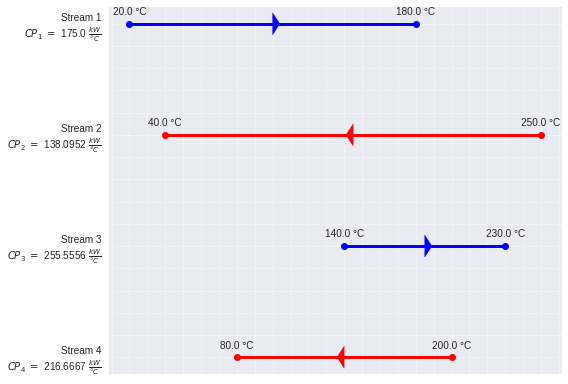

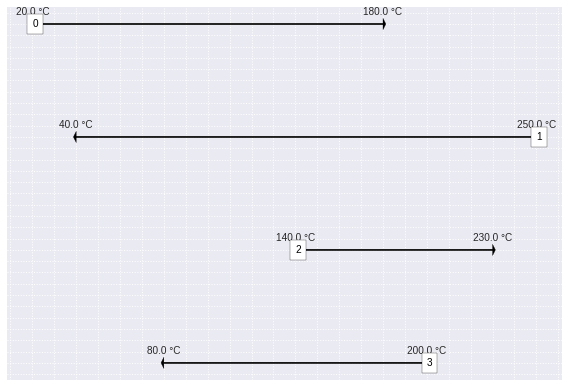

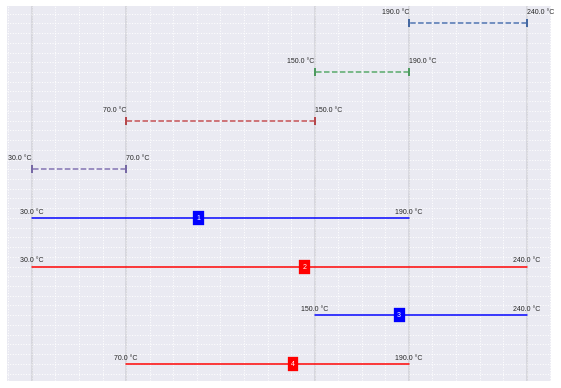

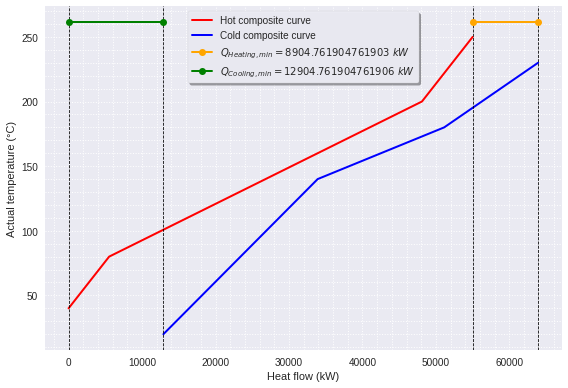

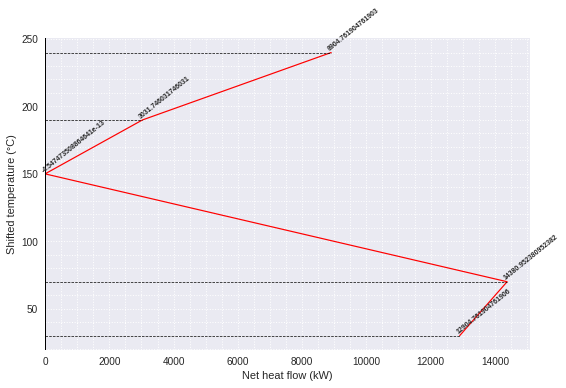

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import tkinter
plt.style.use('seaborn')

class pinchStream(object):
    """
    This class
    """
    def __init__(self, file):
        self.file = str(file)
        global Specifications_array, Specifications
        global T_in, T_out, Q_dot
        global heatFlowSink, ptCascade, temperatures
        global tempSink, tempSource, heatFlowSource, heatFlowSink, CP_stream

        # Load data from text file
        '''Specifications_array = np.loadtxt(self.file+'.txt',
                                          skiprows=1,
                                          unpack=False)'''
        #enter values format  "Heat_tfs" "input_T" "output_T" 
        Specifications_array=[[2.80e+04, 2.00e+01, 1.80e+02],
                              [2.90e+04, 2.50e+02, 4.00e+01],
                              [2.30e+04, 1.40e+02, 2.30e+02],
                              [2.60e+04, 2.00e+02, 8.00e+01]]
        dT=int(input("Please enter Delta Tmin :"))
        for i in range(4):
          Specifications_array[i].append(dT)
        Specifications_array=np.array(Specifications_array)
        # Generate stream list from information on text file
        streamList = {}
        for i in range(0, len(Specifications_array)):
            streamList["Stream_{0}".format(i+1)] = list(Specifications_array[i])
        locals().update(streamList)
        Specifications = list(streamList.values())
        # Separating data by type: heat flow,
        #                          start temperature,
        #                          target temperature
        #                          approach
        Data = [[Specifications[i][0] for i in range(len(Specifications))],
                [Specifications[i][1] for i in range(len(Specifications))],
                [Specifications[i][2] for i in range(len(Specifications))],
                [Specifications[i][3] for i in range(len(Specifications))]]
        # Generate sets for each type
        Q_dot = Data[0]
        T_in = Data[1]
        T_out = Data[2]
        dT_min = Data[3]
        # Calculate the CP for each stream
        CP_stream = np.asarray(Q_dot) / (np.asarray(T_out)-np.asarray(T_in))
        # Get hot and cold stream index
        hotStreamIndex = []
        coldStreamIndex = []
        for i in range(len(Specifications)):
            if Specifications[i][1] > Specifications[i][2]:
                hotStreamIndex.append(i)
            elif Specifications[i][1] < Specifications[i][2]:
                coldStreamIndex.append(i)
        # Calculate source and sink heat flow
        Q_dot_source = 0
        for i in range(len(hotStreamIndex)):
            Q_dot_source = Q_dot_source + Specifications[hotStreamIndex[i]][0]
        Q_dot_sink = 0
        for i in range(len(coldStreamIndex)):
            Q_dot_sink = Q_dot_sink + Specifications[coldStreamIndex[i]][0]
        # Shifted temperature and heat capacity flow hot stream
        for i in range(len(hotStreamIndex)):
            deltaT = 0.5 * Specifications[i][3]
            row = hotStreamIndex[i]
            Specifications[row].append(Specifications[row][1] - deltaT)
            Specifications[row].append(Specifications[row][2] - deltaT)
            Specifications[row].append(Specifications[row][0] / (
                        Specifications[row][5] - Specifications[row][4]))
        # Shifted temperature and heat capacity flow cold stream
        deltaT = 0
        for i in range(len(coldStreamIndex)):
            deltaT = 0.5 * Specifications[i][3]
            row = coldStreamIndex[i]
            Specifications[row].append(Specifications[row][1] + deltaT)
            Specifications[row].append(Specifications[row][2] + deltaT)
            Specifications[row].append(Specifications[row][0] / (
                        Specifications[row][5] - Specifications[row][4]))
        # Get temperatures and intervals
        temperatures = []
        for i in range(len(Specifications)):
            temperatures.append(Specifications[i][4])
            temperatures.append(Specifications[i][5])
        # Get sorting index
        tempInd = np.argsort(temperatures)
        # Get rid of duplicates
        temperatures = set(temperatures)
        temperatures = list(temperatures)
        # Sort temperatures
        temperatures.sort(reverse=True)
        # Set cascade temperatures
        cascade = []
        cascadeSink = []
        cascadeSource = []
        for i in range(len(temperatures) - 1):
            cascade.append([])
            cascadeSink.append([])
            cascadeSource.append([])
            cascade[i].append(temperatures[i])
            cascadeSink[i].append(temperatures[i])
            cascadeSource[i].append(temperatures[i])
            cascade[i].append(temperatures[i + 1])
            cascadeSink[i].append(temperatures[i + 1])
            cascadeSource[i].append(temperatures[i + 1])
        # ===
        for i in range(len(cascade)):
            cascade[i].append(cascade[i][0] - cascade[i][1])
            cascadeSink[i].append(cascade[i][0] - cascade[i][1])
            cascadeSource[i].append(cascade[i][0] - cascade[i][1])
            C_source = 0
            C_sink = 0
            for j in range(len(Specifications)):
                if (cascade[i][0] <= Specifications[j][4]) and (
                        cascade[i][1] >= Specifications[j][5]) and (
                        Specifications[j][6] < 0):
                    C_source = C_source + Specifications[j][6]
            for j in range(len(Specifications)):
                if (cascade[i][0] > Specifications[j][4]) and (
                        cascade[i][1] < Specifications[j][5]) and (
                        Specifications[j][6] > 0):
                    C_sink = C_sink + Specifications[j][6]
            cascade[i].append(C_source + C_sink)
            cascade[i].append(cascade[i][3] * cascade[i][2])
            cascadeSink[i].append(C_sink)
            cascadeSink[i].append(cascadeSink[i][3] * cascadeSink[i][2])
            cascadeSource[i].append(C_source)
            cascadeSource[i].append(cascadeSource[i][3] * cascadeSource[i][2])
        heatFlow = 0
        ptCascade = []
        ptCascade.append(heatFlow)
        for i in range(len(cascade)):
            heatFlow = heatFlow - cascade[i][4]
            ptCascade.append(heatFlow)
        # Calculate recovered and remaining heat flow
        if [n for n in ptCascade if n < 0]:
            Q_dot_rem = min([n for n in ptCascade if n < 0])
        else:
            Q_dot_rem = 0
        Q_dot_rec = Q_dot_sink - abs(Q_dot_rem)
        heatFlow = abs(Q_dot_rem)
        ptCascade = []
        ptCascade.append(heatFlow)
        for i in range(len(cascade)):
            heatFlow = heatFlow - cascade[i][4]
            ptCascade.append(heatFlow)
        # Prepare plot for source
        heatFlowSource = []
        tempSource = []
        heatFlowSource.append(0.)
        for i in reversed(cascadeSource):
            if i[4] < 0:
                heatFlowSource.append(heatFlowSource[-1] + i[4] * -1.)
                tempSource.append(i[0] + deltaT)
                tempSource.append(i[1] + deltaT)
        # Get rid of duplicates
        tempSource = set(tempSource)
        tempSource = list(tempSource)
        # Sort temperatures
        tempSource.sort(reverse=False)
        # Prepare plot for sink
        heatFlowSink = []
        tempSink = []
        # Generating heat flow cascade
        # The last element of cascade corresponds to start of sink
        heatFlowSink.append(ptCascade[-1])
        for i in reversed(cascadeSink):
            if i[4] > 0:
                heatFlowSink.append(heatFlowSink[-1] + i[4])
                tempSink.append(i[0] - deltaT)
                tempSink.append(i[1] - deltaT)
        # Get rid of duplicates
        tempSink = set(tempSink)
        tempSink = list(tempSink)
        # Sort temperatures
        tempSink.sort(reverse=False)

    @staticmethod
    def streamData(T_units='°C', Q_units='kW'):
        """
        This method shows the stream data with its information
        :param T_units: Units for temperature, default is '°C'
        :param Q_units: Units for heat, default is 'kW'
        :return: Table with stream specification, generated on tkinter
        """
        StreamData = tkinter.Tk()
        StreamData.title("Stream specifications")
        StreamData.configure(background='white')
        StreamData.resizable(0, 0)
        header = ("Stream", "Type",
                  "Inlet temperature \n ("+T_units+")",
                  "Outlet temperature \n ("+T_units+")",
                  "Available heat \n ("+Q_units+")")
        colors = ("brown4", "midnight blue", "midnight blue",
                  "midnight blue", "midnight blue")
        for Header, Color, Cell in zip(header, colors, range(len(header))):
            tkinter.Label(text=Header,
                          background=Color,
                          foreground="white",
                          relief="raised",
                          borderwidth=3).grid(row=0, column=Cell + 1,
                                              columnspan=1,
                                              rowspan=1,
                                              sticky='nsew')
        for i in range(len(T_in)):
            tkinter.Label(text=i + 1,
                          background="slate gray",
                          foreground="black",
                          relief="raised",
                          borderwidth=3).grid(row=i + 1, column=1,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for m in range(len(T_in)):
            if T_in[m] > T_out[m]:
                text = "Hot"
                color = "red"
            else:
                text = "Cold"
                color = "blue"
            tkinter.Label(text=text,
                          background="khaki1",
                          foreground=color,
                          relief="ridge",
                          borderwidth=3).grid(row=m + 1, column=2,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for j in range(len(T_in)):
            tkinter.Label(text=T_in[j],
                          background="khaki1",
                          foreground="black",
                          relief="ridge",
                          borderwidth=3).grid(row=j + 1, column=3,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for k in range(len(T_in)):
            tkinter.Label(text=T_out[k],
                          background="khaki1",
                          foreground="black",
                          relief="ridge",
                          borderwidth=3).grid(row=k + 1, column=4,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for n in range(len(T_in)):
            tkinter.Label(text=Q_dot[n],
                          background="khaki1",
                          foreground="black",
                          relief="ridge",
                          borderwidth=3).grid(row=n + 1, column=5,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        StreamData.mainloop()

    @staticmethod
    def drawStreams(Data='1', T_units='°C', Q_units='kW'):
        """
        This method draws a plot of corresponding streams
        :param Data: Name for the set of streams
        :param T_units: Units for temperature, default is '°C'
        :param Q_units: Units for heat, default is 'kW'
        :return:
        """
        global figStreams, axStreams
        figStreams = plt.figure()
        figStreams.canvas.set_window_title('Streams for data')
        axStreams = figStreams.add_subplot(111)
        axStreams.minorticks_on()
        axStreams.grid(True, which='BOTH', ls=':')
        labels = []
        if Q_units == 'kW':
            Q_denom = 'kW'
            Q_numer = ''
        elif Q_units == 'BTU/h':
            Q_denom = 'BTU'
            Q_numer = 'h \\times'
        else:
            pass
        for j in range(len(T_in)+1):
            labels.append("Stream " +
                          str(j)+"\n" +
                          "$CP_{" + str(j)+"}" + "\ = \ $" +
                          str(round(abs(CP_stream[j-1]), 4)) +
                          "$ \ \\frac{" + Q_denom +
                          "}{" +
                          Q_numer +
                          T_units +
                          "}$")
        axStreams.set_yticklabels(labels)
        axStreams.set_xticklabels([])
        for k in range(len(T_in)):
            if T_in[k] > T_out[k]:
                colorLine = 'red'
            else:
                colorLine = 'blue'
            axStreams.plot([T_in[k], T_out[k]], [k+1, k+1], color=colorLine,
                           linestyle='-', linewidth=3, marker='o')
            axStreams.arrow(T_in[k], k+1, (T_out[k]-T_in[k])/2, 0,
                            head_width=0.2, head_length=4, color=colorLine)
            axStreams.annotate(str(T_in[k])+" "+T_units,
                               xy=(T_in[k], k+0.92), ha='center')
            axStreams.annotate(str(T_out[k])+" "+T_units,
                               xy=(T_out[k], k+0.92), ha='center')
        axStreams.yaxis.set_major_locator(MaxNLocator(integer=True))
        axStreams.invert_yaxis()
        figStreams.tight_layout()
        figStreams.savefig(Data + '_drawStreams.jpg',
                           bbox_inches="tight")
        return plt.show()

    @staticmethod
    def shiftedTemperatures(T_units='°C'):
        """
        This function
        :param T_units: Units for temperature, default is '°C'
        :return:
        """
        ShiftedTemperatures = tkinter.Tk()
        ShiftedTemperatures.title("Table of shifted temperatures")
        ShiftedTemperatures.configure(background='khaki1')
        ShiftedTemperatures.resizable(0, 0)
        header = ("Stream",
                  "Inlet temperature \n ("+T_units+")",
                  "Outlet temperature \n ("+T_units+")",
                  "Shifted inlet temperature \n ("+T_units+")",
                  "Shifted outlet temperature \n ("+T_units+")")
        colors = ("brown4", "midnight blue", "midnight blue",
                  "midnight blue", "midnight blue")
        for Header, Color, Cell in zip(header, colors, range(len(header))):
            tkinter.Label(ShiftedTemperatures,
                          text=Header,
                          background=Color,
                          foreground="white",
                          relief="raised",
                          borderwidth=3).grid(row=0, column=Cell + 1,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for i in range(len(T_in)):
            tkinter.Label(ShiftedTemperatures,
                          text=i + 1,
                          background="slate gray",
                          foreground="black",
                          relief="raised",
                          borderwidth=3).grid(row=i + 1, column=1,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for j in range(len(T_in)):
            tkinter.Label(ShiftedTemperatures,
                          text=T_in[j],
                          background="khaki1",
                          foreground="black",
                          relief="ridge",
                          borderwidth=3).grid(row=j + 1, column=2,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for j in range(len(T_out)):
            tkinter.Label(ShiftedTemperatures,
                          text=T_out[j],
                          background="khaki1",
                          foreground="black",
                          relief="ridge",
                          borderwidth=3).grid(row=j + 1, column=3,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for j in range(len(T_out)):
            tkinter.Label(ShiftedTemperatures,
                          text=Specifications[j][4],
                          background="khaki1",
                          foreground="black",
                          relief="ridge",
                          borderwidth=3).grid(row=j + 1, column=4,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for j in range(len(T_out)):
            tkinter.Label(ShiftedTemperatures,
                          text=Specifications[j][5],
                          background="khaki1",
                          foreground="black",
                          relief="ridge",
                          borderwidth=3).grid(row=j + 1, column=5,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')

        ShiftedTemperatures.mainloop()

    @staticmethod
    def cascadeTable(T_units='°C', Q_units='kW'):
        """
        This method
        :param T_units: Units for temperature, default is '°C'
        :param Q_units: Units for heat, default is 'kW'
        :return:
        """
        Cascade = tkinter.Tk()
        Cascade.title("Table of heat cascade")
        Cascade.configure(background='khaki1')
        Cascade.resizable(0, 0)
        header = ("Temperature  ("+T_units+")",
                  "Heat  ("+Q_units+")")
        colors = ("midnight blue", "midnight blue")
        for Header, Color, Cell in zip(header, colors, range(len(header))):
            tkinter.Label(text=Header,
                          background=Color,
                          foreground="white",
                          relief="raised",
                          borderwidth=3).grid(row=0, column=Cell + 1,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for j in range(len(temperatures)):
            tkinter.Label(Cascade,
                          text=temperatures[j],
                          background="khaki1",
                          foreground="black",
                          relief="ridge",
                          borderwidth=3).grid(row=j+1, column=1,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        for j in range(len(ptCascade)):
            tkinter.Label(Cascade,
                          text=ptCascade[j],
                          background="khaki1",
                          foreground="black",
                          relief="ridge",
                          borderwidth=3).grid(row=j+1, column=2,
                                              columnspan=1,
                                              rowspan=1, sticky='nsew')
        Cascade.mainloop()

    @staticmethod
    def compositeCurve(Data='1', T_units='°C', Q_units='kW'):
        """
        This method
        :param Data: Name for the set of streams
        :param T_units: Units for temperature, default is '°C'
        :param Q_units: Units for heat, default is 'kW'
        :return:
        """
        global fig1, ax1
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        fig1.canvas.set_window_title('Hot and cold composite curves')
        ax1.plot(heatFlowSource, tempSource, 'r',
                 linewidth=2, label="Hot composite curve")
        ax1.plot(heatFlowSink, tempSink, 'b',
                 linewidth=2, label="Cold composite curve")
        ax1.axvline(x=min(heatFlowSource), color='k',
                    linestyle='--', linewidth=0.8)
        ax1.axvline(x=min(heatFlowSink), color='k',
                    linestyle='--', linewidth=0.8)
        ax1.axvline(x=max(heatFlowSource), color='k',
                    linestyle='--', linewidth=0.8)
        ax1.axvline(x=max(heatFlowSink), color='k',
                    linestyle='--', linewidth=0.8)
        ax1.minorticks_on()
        ax1.grid(which='BOTH', ls=':')
        ax1.grid(True)
        ax1.set_xlabel('Heat flow (' + Q_units + ')')
        ax1.set_ylabel('Actual temperature (' + T_units + ')')
        y_down, y_up = ax1.get_ylim()
        x1 = [max(heatFlowSource), max(heatFlowSink)]
        x2 = [min(heatFlowSource), min(heatFlowSink)]
        y1 = [y_up, y_up]
        ax1.plot(x1, y1, linestyle='-', color='orange', linewidth=2,
                 label="$Q_{Heating, min} = " + str(ptCascade[0]) + " \ " +
                       Q_units + "$", marker='o')
        ax1.plot(x2, y1, linestyle='-', color='green', linewidth=2,
                 label="$Q_{Cooling, min} = " + str(ptCascade[-1]) + " \ " +
                       Q_units + "$", marker='o')
        ax1.legend(loc="best", fancybox=True, shadow=True,
                   framealpha=0.98, frameon=True)
        fig1.tight_layout()
        fig1.savefig(Data + '_CompositeCurve.jpg',
                     bbox_inches="tight")
        return plt.show()

    @staticmethod
    def grandCompositeCurve(Data='1', T_units='°C', Q_units='kW'):
        """
        This method
        :param Data: Name for the set of streams
        :param T_units: Units for temperature, default is '°C'
        :param Q_units: Units for heat, default is 'kW'
        :return:
        """
        fig2 = plt.figure()
        ax2 = fig2.add_subplot(111)
        fig2.canvas.set_window_title('Grand composite curve')
        ax2.plot(ptCascade, temperatures, 'r',
                 linewidth=1.2, label="_nolegend_")
        ax2.set_xlim([min(ptCascade), None])
        ax2.axvline(x=min(ptCascade), color='k', linestyle='-', linewidth=2)
        for k in range(len(temperatures)):
            x_1 = min(ptCascade)
            x_2 = ptCascade[k]
            y_1 = temperatures[k]
            y_2 = y_1
            x = [x_1, x_2]
            y = [y_1, y_2]
            ax2.plot(x, y, linestyle='--', color='k', linewidth=0.7,
                     label="_nolegend_")
            ax2.text(x_2, y_2, str(ptCascade[k]), verticalalignment='bottom',
                     horizontalalignment='left', fontsize=7, fontweight='bold',
                     label="_nolegend_", wrap=True, rotation=39)
            if ptCascade[k] == 0:
                ax2.axhline(y=temperatures[k], linestyle='--', color='blue',
                            linewidth=0.9, label="$T_{pinch} \ =$" + str(
                                temperatures[k]) + ' ' + T_units)
                ax2.legend(loc="best", fancybox=True, shadow=True)
            else:
                pass
        ax2.minorticks_on()
        ax2.grid(True, which='BOTH', ls=':')
        ax2.set_xlabel('Net heat flow (' + Q_units + ')')
        ax2.set_ylabel('Shifted temperature (' + T_units + ')')
        fig2.savefig(Data+'_grandCompositeCurve.jpg', bbox_inches="tight")
        fig2.tight_layout()
        return plt.show()

    @staticmethod
    def drawCascade(T_units='°C', Q_units='kW'):
        """
        This funtion
        :param T_units: Units for temperature, default is '°C'
        :param Q_units: Units for heat, default is 'kW'
        :return:
        """
        heatCascade = tkinter.Tk()
        heatCascade.title("Cascade of temperature intervsls,"
                          "energy balances and residuals")
        heatCascade.configure(background='white')
        emptyCellsTemperatures = len(temperatures)*[""]
        arraysTemperatures = list(zip(emptyCellsTemperatures, temperatures))
        cellsTemperatures = []
        for i in range(len(arraysTemperatures)):
            cellsTemperatures.extend(arraysTemperatures[i])

        emptyCellsCascade = len(ptCascade) * [""]
        arraysCascade = list(zip(ptCascade, emptyCellsCascade))
        cellsCascade = []
        for i in range(len(arraysCascade)):
            cellsCascade.extend(arraysCascade[i])

        for k in range(len(cellsTemperatures)):
            if cellsTemperatures[k] != "":
                tempLabel = tkinter.Text(heatCascade, foreground='black',
                                         background='white', relief='ridge',
                                         borderwidth=1, height=2, width=21)
                tempLabel.tag_configure("subscript", offset=-1)
                tempLabel.insert("insert", "T", "", str(k), "subscript",
                                 " = "+str(cellsTemperatures[k])+" "+T_units)
                tempLabel.configure(state="disabled")
                tempLabel.grid(row=k, column=0, columnspan=1,
                               rowspan=1, sticky='nsew')
            else:
                tempLabel = tkinter.Text(heatCascade, foreground='black',
                                         background='white', relief='ridge',
                                         borderwidth=1, height=2, width=21)
                tempLabel.tag_configure("subscript", offset=-1)
                tempLabel.insert("insert", "")
                tempLabel.configure(state="disabled")
                tempLabel.grid(row=k, column=0, columnspan=1,
                               rowspan=1, sticky='nsew')
        for k in range(len(cellsCascade)):
            if cellsTemperatures[k] == "":
                heatLabel = tkinter.Text(heatCascade, foreground='black',
                                         background='white', relief='ridge',
                                         borderwidth=1, width=21, height=2)
                heatLabel.tag_configure("subscript", offset=-1)
                heatLabel.insert("insert", "Q", "", str(k), "subscript",
                                 " = " + str(cellsCascade[k]) + " " + Q_units)
                heatLabel.configure(state="disabled")
                heatLabel.grid(row=k, column=1, columnspan=1,
                               rowspan=1, sticky='nsew')
            else:
                heatLabel = tkinter.Text(heatCascade, foreground='black',
                                         background='white', relief='ridge',
                                         width=21, height=2)
                heatLabel.insert("insert", "")
                heatLabel.grid(row=k, column=1, columnspan=1,
                               rowspan=1, sticky='nsew')
        heatCascade.mainloop()

    @staticmethod
    def initialGridDiagram(Data='1', T_units='°C'):
        """
        This method
        :param Data: Name for the set of streams
        :param T_units: Units for temperature, default is '°C'
        :return:
        """
        figGrid, axGrid = plt.subplots()
        figGrid.canvas.set_window_title('Initial grid diagram')
        axGrid.minorticks_on()
        axGrid.grid(True, which='BOTH', ls=':')
        for i in range(len(T_in)):
            axGrid.plot([T_in[i], T_out[i]], [i + 1, i + 1],
                        color='black', linestyle='-', linewidth=1.5)
            axGrid.arrow(T_in[i], i + 1, T_out[i] - T_in[i], 0,
                         head_width=0.1, head_length=1.3, color='black')
            axGrid.annotate(str(T_in[i]) + " " + T_units,
                            xy=(T_in[i], i + 0.92), ha='center')
            axGrid.annotate(str(T_out[i]) + " " + T_units,
                            xy=(T_out[i], i + 0.92), ha='center')
            axGrid.text(T_in[i], i + 1,
                        str(i), color='black',
                        bbox=dict(facecolor='white',
                                  edgecolor='black',
                                  boxstyle='square,pad=0.5'),
                        horizontalalignment='left',
                        verticalalignment='center')
        axGrid.set_xticklabels([])
        axGrid.set_yticklabels([])
        axGrid.invert_yaxis()
        figGrid.tight_layout()
        figGrid.savefig(Data + '_initialGridDiagram.jpg', bbox_inches="tight")
        return plt.show()

    @staticmethod
    def drawIntervals(Data='1', T_units='°C'):
        """
        This method
        :param Data: Name for the set of streams
        :param T_units: Units for temperature, default is '°C'
        :return:
        """
        figIntervals, axIntervals = plt.subplots()
        figIntervals.canvas.set_window_title('Intervals')
        axIntervals.minorticks_on()
        axIntervals.grid(True, which='BOTH', ls=':')
        for i in range(len(temperatures)-1):
            axIntervals.plot([temperatures[i], temperatures[i+1]],
                             [i + 1, i + 1],
                             linestyle='--', linewidth=1.5, marker='$▌$')
            axIntervals.annotate(str(temperatures[i]) + " " + T_units,
                                 xy=(temperatures[i], i + 0.8),
                                 ha='left', fontsize=7)
            axIntervals.annotate(str(temperatures[i+1]) + " " + T_units,
                                 xy=(temperatures[i+1], i + 0.8),
                                 ha='right', fontsize=7)
        for j in range(len(temperatures)):
            axIntervals.axvline(x=temperatures[j], color='black',
                                linestyle=':', linewidth=0.4)
        for k in range(len(T_in)):
            if T_in[k] > T_out[k]:
                colorLine = 'red'
            else:
                colorLine = 'blue'
            axIntervals.plot([Specifications[k][4], Specifications[k][5]],
                             [k + len(temperatures), k + len(temperatures)],
                             color=colorLine, linestyle='-', linewidth=1.5)
            axIntervals.annotate(str(Specifications[k][4]) + " " + T_units,
                                 xy=(Specifications[k][4],
                                     k + 0.98*len(temperatures)),
                                 ha='center', fontsize=7)
            axIntervals.annotate(str(Specifications[k][5]) + " " + T_units,
                                 xy=(Specifications[k][5],
                                     k + 0.98*len(temperatures)),
                                 ha='center', fontsize=7)
            axIntervals.text(T_in[k] + (T_out[k]-T_in[k])/2,
                             k + len(temperatures),
                             str(k+1), color='white',
                             bbox=dict(facecolor=colorLine,
                                       edgecolor=colorLine,
                                       boxstyle='square,pad=0.5'),
                             horizontalalignment='left',
                             verticalalignment='center',
                             fontsize=7)
        axIntervals.set_xticklabels([])
        axIntervals.set_yticklabels([])
        axIntervals.invert_yaxis()
        figIntervals.tight_layout()
        figIntervals.savefig(Data + '_drawIntervals.jpg', bbox_inches="tight")
        return plt.show()


if __name__ == '__main__':
  data = pinchStream('Data6')
  data.drawStreams(Data="3")
  data.initialGridDiagram(Data="3")
  data.drawIntervals(Data="3")
  data.compositeCurve(Data="3")
  data.grandCompositeCurve(Data="1")